# Conv3d refinements and explainability

In [1]:
import os
import cv2
import numpy as np
import datetime as dt
import shutil
import pandas as pd
import random
from itertools import product
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps

import tensorflow as tf

from keras.layers import *
from keras.models import Sequential
from keras.utils import plot_model, to_categorical
from keras.models import load_model
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score


In [2]:
# List files and ignore .DS_Store if on a Mac
def list_files(directory):
    visible_files = []
    for file in os.listdir(directory):
        if not file.startswith('.'):
            visible_files.append(file)

    return visible_files


# Convert video to frames
def video_to_frames(video_path, img_size, sequence_length):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, img_size)
        frames.append(frame)
        if len(frames) == sequence_length:
            break
    cap.release()

    if len(frames) < sequence_length:
        return None  # Ignore short videos

    return np.array(frames)


# Load and Preprocess Videos
def load_videos_from_folders(folder_path, img_size=(64, 64), sequence_length=30):
    # classes = os.listdir(folder_path)
    classes = list_files(folder_path)
    data, labels = [], []

    for label, activity in enumerate(classes):
        activity_folder = os.path.join(folder_path, activity)
        # for video_file in os.listdir(activity_folder):
        for video_file in list_files(activity_folder):
            video_path = os.path.join(activity_folder, video_file)
            frames = video_to_frames(video_path, img_size, sequence_length)
            if frames is not None:
                data.append(frames)
                labels.append(label)

    data = np.array(data)
    labels = to_categorical(labels, num_classes=len(classes))

    return data, labels, classes


# List class names from labeled folders
def get_classes(directory):
    # Get Names of all classes
    classes = list_files(directory)
    # classes = enumerate(classes)

    return classes


# Predict all videos in 
def predict_all3d(model, data, idx, labels, classes):

    # Interpreting the data structure
    predict_idx = idx
    selected_data = data[predict_idx]
    selected_labels = labels[predict_idx]
    true_label = np.argmax(selected_labels, axis=0)
    true_class = classes[true_label]

    # Add extra dimension
    reshaped_data = tf.expand_dims(selected_data, axis=0)

    test_predictions = model.predict(reshaped_data)

    predicted_label = np.argmax(test_predictions, axis=1)
    predicted_class = classes[predicted_label[0]]

    print(f'Predicted class: {predicted_class}\tTrue class: {true_class}')

    if predicted_label == true_label:
        correct = True
    else:
        correct = False

    return predicted_label, predicted_class, true_label, true_class, correct


# Select a random video
def select_random(dir):
    # Get classes
    classes = get_classes(dir)

    # Select random class
    random_class = random.choice(classes)

    # Get all files in random class directory
    path = f'{dir}/{random_class}'
    files = list_files(path)

    # Select random video
    random_video = random.choice(files)
    random_path = f'{path}/{random_video}'

    return random_class, random_path


# Predict activity for one video
def predict_one3d(model, dir, random=False, **kwargs):

    classes = get_classes(dir)

    if random:
        classname, path = select_random(dir)

        # Get random video for a specified class
        if 'classname' in kwargs:
            classname = kwargs.get("classname")
        
    else:
        classname = kwargs.get("classname")
        file = kwargs.get("file")
        path = f"../downloads/r2_test/{classname}/{file}"

    print(f'Predicting {path}\n')

    frames = video_to_frames(path, img_size=(64, 64), sequence_length=30)
    frames = np.array([frames])

    test_predictions = model.predict(frames)

    predicted_label = np.argmax(test_predictions, axis=1)
    predicted_label = predicted_label[0]
    predicted_class = classes[predicted_label]

    print(f'Predicted label: {predicted_label}\tPredicted class: {predicted_class}\tTrue class: {classname}')

    return predicted_label, predicted_class, classname


## Access data, labels, and classes in the dataset

In [8]:
# Get data from the directory
test_data_folder = "../../downloads/fr_10s/test_fr_10s"
data, labels, classes = load_videos_from_folders(test_data_folder)

In [9]:
# data[0][0]
print("[")
for d in data[0][0][0]:
    new = [d[0], d[1], d[2]]
    print(f'{new},')
print("]")

[
[117, 117, 117],
[108, 108, 108],
[102, 102, 102],
[111, 111, 111],
[107, 107, 107],
[101, 101, 101],
[104, 104, 104],
[95, 95, 95],
[95, 95, 95],
[102, 102, 102],
[86, 86, 86],
[92, 92, 92],
[78, 78, 78],
[78, 78, 78],
[74, 74, 74],
[127, 127, 127],
[57, 57, 57],
[51, 51, 51],
[34, 34, 34],
[68, 68, 68],
[57, 57, 57],
[60, 60, 60],
[62, 62, 62],
[62, 62, 62],
[65, 65, 65],
[62, 62, 62],
[62, 62, 62],
[62, 62, 62],
[62, 62, 62],
[60, 60, 60],
[59, 59, 59],
[59, 59, 59],
[59, 59, 59],
[59, 59, 59],
[61, 61, 61],
[64, 64, 64],
[61, 61, 61],
[61, 61, 61],
[61, 61, 61],
[61, 61, 61],
[61, 61, 61],
[60, 60, 60],
[59, 59, 59],
[57, 57, 57],
[46, 46, 46],
[51, 51, 51],
[51, 51, 51],
[50, 50, 50],
[50, 50, 50],
[48, 48, 48],
[46, 46, 46],
[46, 46, 46],
[45, 45, 45],
[44, 44, 44],
[41, 41, 41],
[40, 40, 40],
[39, 39, 39],
[39, 39, 39],
[37, 37, 37],
[36, 36, 36],
[33, 33, 33],
[31, 31, 31],
[30, 30, 30],
[27, 27, 27],
]


### Accessing static frames from data

In [10]:
# Number of sequences 
total_sequences = len(data)
sequences_per_class = total_sequences / 10
one_video = data[0]
sequence_len = len(one_video)

# 2nd arg in conv_filters param
one_frame = one_video[0][0]
frame_size = len(one_frame)  # 64x64 image

# I think each row is the max pooled result of the kernel stride for the image
max_pooled_kernel = one_frame[0]  # these are RGB values 
pooled_kernel_size = len(max_pooled_kernel)  # result = 3, kernel is 3x3x3, so it pools 27 pixels

print(f"Num sequences: {total_sequences}") 
print(f"Sequences per class: {sequences_per_class}") 
print(f"Sequence len: {sequence_len}")
print(f"Frame size: {frame_size}")
print(f"Max pooled kernel size: {pooled_kernel_size}")

Num sequences: 1106
Sequences per class: 110.6
Sequence len: 30
Frame size: 64
Max pooled kernel size: 3


## Load a trained model

In [11]:
# Load model
model_path = './2024-11-18-11-43-35-conv3d-model.keras'
model = load_model(model_path)

## Predict one video

In [18]:
# Predict a random video from the test set
directory = "../../downloads/fr_10s/test_fr_10s"
predicted_label, predicted_class, classname = predict_one3d(model, directory, random=True)

Predicting ../../downloads/fr_10s/test_fr_10s/Asleep-Trying to sleep/7394814763244768401_s_1.mp4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label: 0	Predicted class: Asleep-Trying to sleep	True class: Asleep-Trying to sleep


In [23]:
# Predict a random video from specified class
directory = "../../downloads/fr_10s/test_fr_10s"
specified_class = "Resting"

predicted_label, predicted_class, classname = predict_one3d(model=model, 
                                                            dir = directory, 
                                                            random = True,
                                                            classname = specified_class)

Predicting ../../downloads/fr_10s/test_fr_10s/Asleep-Trying to sleep/7394603871760600209_s_5.mp4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted label: 5	Predicted class: Lying In Bed	True class: Resting


In [269]:
# Predict a specified video from a directory
directory = "../downloads/r2_test"
classname = "Resting"
specified_vid = "7393499193287167121_r7.mp4"

predicted_label, predicted_class, classname = predict_one3d(model=model, 
                                                            dir = directory, 
                                                            random = False,
                                                            classname = classname, 
                                                            file = specified_vid)


Predicting ../downloads/r2_test/Resting/7393499193287167121_r7.mp4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted label: 5	Predicted class: Nurse-Doctor visit	True class: Resting


# Predict entire test set

In [ ]:
# Track correct predictions
correct_predictions = 0
incorrect_predictions = 0

idx = 0

predicted_labels = []
predicted_classes = []
true_labels = []
true_classes = []

# Iterate though test directory
while idx < len(data):

    pl, pc, tl, tc, correct = predict_all3d(model, data, idx, labels, classes)
    predicted_labels.append(pl)
    predicted_classes.append(pc)
    true_labels.append(tl)
    true_classes.append(tc)

    if correct:
        correct_predictions += 1
    else:
        incorrect_predictions += 1

    idx += 1

print(f'Correct: {correct_predictions}\tIncorrect: {incorrect_predictions}')

# Save data
results_df = pd.DataFrame({"Predicted label": predicted_labels, 
                           "Predicted class": predicted_classes,
                           "True label": true_labels, 
                           "True class": true_classes})

date_time_format = '%Y-%m-%d-%H-%M-%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

file = f'../../data/{current_date_time_string}-conv3d-testing.csv'

results_df.to_csv(file, index=False) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class: Asleep-Trying to sleep	True class: Asleep-Trying to sleep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: Asleep-Trying to sleep	True class: Asleep-Trying to sleep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class: Asleep-Trying to sleep	True class: Asleep-Trying to sleep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: Asleep-Trying to sleep	True class: Asleep-Trying to sleep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: Asleep-Trying to sleep	True class: Asleep-Trying to sleep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: Asleep-Trying to sleep	True class: Asleep-Trying to sleep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class: Asleep-Trying to sleep	True class: Asleep-Trying to sleep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: Asleep-Trying to sleep	True class: Asleep-Trying to sleep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: Asleep-Trying to sleep	True class: Asleep

In [28]:
# Function to plot confusion matrix. This prevents notebooks from printing the plot twice.
def plot_confusion(t_class, p_class, title, cmap='turbo', **kwargs):

    # Define plot design
    title = title
    title_size = 'xx-large'
    label_size = 'large'
    tick_size = 'small'
    colors = cmap
    padding = 14

    if 'display_labels' in kwargs:
        d_labels = kwargs.get("display_labels")

    fig, ax = plt.subplots(figsize=(8,6))

    # plt.suptitle(title, fontsize = title_size)
    plt.title(title, fontsize = title_size, pad=padding * 1.25)
    plt.xticks(fontsize = tick_size)
    plt.yticks(fontsize = tick_size)
    plt.ylabel("True label", fontsize = label_size, labelpad=padding)
    plt.xlabel("Predicted label", fontsize = label_size, labelpad=padding)
    plt.subplots_adjust(bottom=0.35)

    if 'display_labels' in kwargs:
        d_labels = kwargs.get("display_labels")
        cm = ConfusionMatrixDisplay.from_predictions(t_class, p_class, cmap=colors, display_labels=d_labels)
    else:
        cm = ConfusionMatrixDisplay.from_predictions(t_class, p_class, cmap=colors)

    cm.plot(ax=ax, 
            xticks_rotation='vertical', 
            cmap=colors)
    
    plt.close()

    return fig

In [29]:
# Function to load saved model and evaluate on new test data
def load_and_evaluate_model(model_path, test_data_folder, img_size=(64, 64), sequence_length=30, plot=False):
    # Load the trained model
    model = load_model(model_path)
    print(" ")
    print(f'Loaded model from: {model_path}')

    # Load and preprocess the test data
    print(" ")
    print('Preprocessing')

    test_data, test_labels, activity_classes = load_videos_from_folders(test_data_folder, img_size, sequence_length)

    print(test_data, test_labels, activity_classes)
    # Make predictions
    print(" ")
    print('Making predictions')
    print(" ")

    predicted_labels = []
    true_labels = []

    for t in test_data:
    # test_predictions = model.predict(test_data)
        prediction = model.predict(t)

        # Convert predictions and labels to class indices
        pl = np.argmax(prediction, axis=1)
        predicted_labels.append(pl)
        tl = np.argmax(test_labels, axis=1)
        true_labels.append(tl)

    predicted_labels = ()
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(" ")
    print("=========================================")
    print(f"Test Accuracy: {accuracy}")
    print("=========================================")
    print(" ")

    if plot:
        # Generate confusion matrix
        # cmap = plt.cm.Blues
        cm = plot_confusion(t_class = true_labels, 
                            p_class = predicted_labels,
                            display_labels = activity_classes, 
                            title = "Conv3D Confusion")
        
        # Make classification report
        report = classification_report(true_labels, predicted_labels)
        print(report)

        return accuracy, predicted_labels, true_labels, cm

    else:
        return accuracy, predicted_labels, true_labels

In [31]:
results_df

,Predicted label,Predicted class,True label,True class
0,[0],Asleep-Trying to sleep,0,Asleep-Trying to sleep
1,[0],Asleep-Trying to sleep,0,Asleep-Trying to sleep
2,[0],Asleep-Trying to sleep,0,Asleep-Trying to sleep
3,[0],Asleep-Trying to sleep,0,Asleep-Trying to sleep
4,[0],Asleep-Trying to sleep,0,Asleep-Trying to sleep
...,...,...,...,...
1101,[0],Asleep-Trying to sleep,11,Watching TV
1102,[0],Asleep-Trying to sleep,11,Watching TV
1103,[0],Asleep-Trying to sleep,11,Watching TV
1104,[0],Asleep-Trying to sleep,11,Watching TV


                        precision    recall  f1-score   support

Asleep-Trying to sleep       0.39      0.78      0.52       290
          Doctor Visit       0.00      0.00      0.00         2
             EVS Visit       0.14      0.10      0.12        41
                Eating       0.00      0.00      0.00       150
                Family       0.72      1.00      0.84        66
          Lying In Bed       0.30      0.15      0.20       105
           Nurse Visit       0.15      0.16      0.15       150
 Sitting In Wheelchair       0.96      0.28      0.43        86
  Talking on the Phone       0.00      0.00      0.00        55
               Therapy       1.00      1.00      1.00         9
       Transfer To Bed       1.00      1.00      1.00         2
           Watching TV       0.17      0.05      0.08       150

              accuracy                           0.34      1106
             macro avg       0.40      0.38      0.36      1106
          weighted avg       0.31     

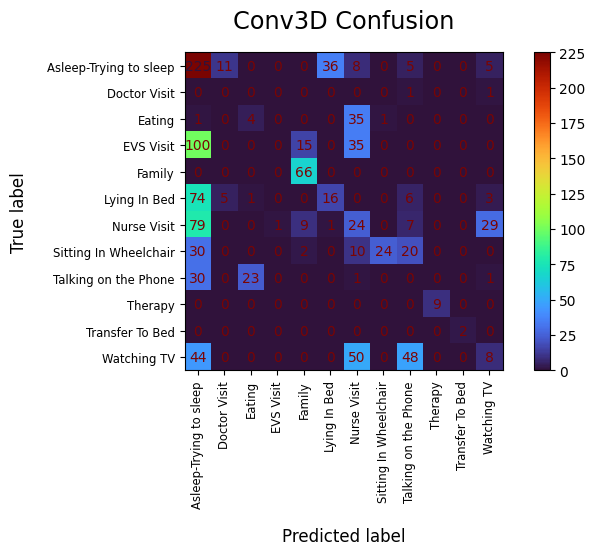

In [33]:
tc = results_df['True class']
pc = results_df['Predicted class']

cm = plot_confusion(t_class = tc, 
                    p_class = pc,
                    display_labels = classes, 
                    title = "Conv3D Confusion")

# Make classification report
report = classification_report(tc, pc)
print(report)